# Imports

In [1]:
from utils import *
import os
import shutil
from PIL import Image
from pytorch_fid import fid_score
import copy

import torch.distributions as D

import torch.optim.lr_scheduler as lrsc
import wandb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

from config import *
config = get_configs()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
wandb.login()
train_loader, val_loader = get_datasets(config)

wandb: Currently logged in as: vvoganesyan (use `wandb login --relogin` to force relogin)


# Sampling

In [2]:
eps_th = Unet(config)
eps_th.to(device)
ema_ = ema.ExponentialMovingAverage(eps_th.parameters(), decay=0.9999)

In [3]:
state = torch.load(config.model.savepath)
eps_th.load_state_dict(state['model'], strict=False)
ema_.load_state_dict(state['ema'])

In [4]:
ema_.copy_to(eps_th.parameters())
eps_th.eval()

Unet(
  (unet): DDPM(
    (act): SiLU()
    (all_modules): ModuleList(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ResnetBlockDDPM(
        (GroupNorm_0): GroupNorm(32, 32, eps=1e-06, affine=True)
        (act): SiLU()
        (Conv_0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Dense_0): Linear(in_features=128, out_features=32, bias=True)
        (GroupNorm_1): GroupNorm(32, 32, eps=1e-06, affine=True)
        (Dropout_0): Dropout(p=0.1, inplace=False)
        (Conv_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): ResnetBlockDDPM(
        (GroupNorm_0): GroupNorm(32, 32, eps=1e-06, affine=True)
        (act): SiLU()
        (Conv_0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Dense_0): Linear(in_features=128, out_fe

# One model

In [5]:
val_dataset_iter = iter(val_loader)
x, y = val_dataset_iter.next()
x = x.to(device)
x_noised = noising_PET_image( (x+1.0)/2, 60.0/90, 2.0/3)
x_noised = 2*x_noised-1.0

In [7]:
z_restored, z = restore_image(x_noised, 0.22, device, eps_th)

In [8]:
err = torch.abs(x - z_restored)-1

In [9]:
n = 16
big_img = np.zeros((n*32,5*32),dtype=np.uint8)
for i, batch in enumerate([x, x_noised, z, z_restored, err]):
    for j, p in enumerate(batch):
        if j<n:
            p = p*0.5 + 0.5
            p = p * 255
            p = p.clamp(0, 255)
            p = p.detach().cpu().numpy()
            p = p.astype(np.uint8)
            p = p.transpose((1,2,0))
            big_img[j*32:(j+1)*32, i*32:(i+1)*32] = p[:,:,0]

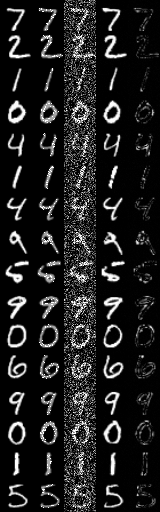

In [10]:
big_img = Image.fromarray(big_img)
big_img

In [5]:
with torch.no_grad():
    save_callable(lambda: sample_sde(device, eps_th, config.data.image_size, config.data.num_channels, 128), "sampled_images", 128)

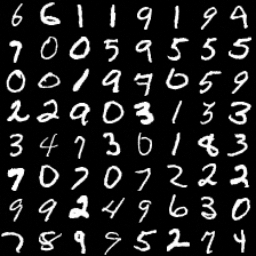

In [8]:
big_img = np.zeros((8*32,8*32),dtype=np.uint8)
for i in range(8):
    for j in range(8):
        im = Image.open(f"sampled_images/{i*8+j}.png")
        big_img[i*32:(i+1)*32, j*32:(j+1)*32] = np.array(im)
big_img = Image.fromarray(big_img)
big_img

In [15]:
save_dataloader(train_loader, 'data_1', 128*128)

In [13]:
res = fid_score.calculate_fid_given_paths(
        paths=['data_1', 'data_2'],
        batch_size=128,
        device=device,
        dims=2048
    )
print(res)

100%|██████████| 128/128 [00:34<00:00,  3.73it/s]


10.201483234328634
